<a href="https://colab.research.google.com/github/james-yu2005/Affi-NN-ity/blob/main/HiQBindESMEmbeddingMorganFingerprints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q scikit-learn pandas tqdm deepchem rdkit torch torch-geometric fair-esm biopython

In [ ]:
!pip install PyTDC

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import torch
import torch.nn.functional as F
from torch.nn import Linear, ReLU, Sequential, BatchNorm1d, Dropout, LayerNorm
import torch_geometric
from torch_geometric.nn import GINConv, global_add_pool, global_mean_pool
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader
import numpy as np
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
import deepchem as dc
import pandas as pd
import esm
import pickle
from Bio import PDB
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import KFold
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts
import copy
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


**ETL Pipeline for HiQBind**


In [ ]:
import os
from google.colab import drive

# 1. Mount Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

FILENAME = "hiqbind_sm_metadata.csv"

print(f"🕵️ Searching entire Drive for: {FILENAME}...")
print("(This takes about 30-60 seconds)...")

found = False
# Start searching from the top of MyDrive
for root, dirs, files in os.walk("/content/drive/MyDrive"):
    if FILENAME in files:
        full_path = os.path.join(root, FILENAME)
        found = True

        print("\n" + "="*60)
        print("✅ FOUND IT!")
        print(f"Exact CSV Path:  {full_path}")
        print(f"Parent Folder:   {root}")
        print("="*60)

        # Check if the 'hiqbind' subfolder exists here too (for raw data)
        raw_check = os.path.join(root, "hiqbind")
        if os.path.exists(raw_check):
             print(f"✅ Found 'hiqbind' subfolder here too!")
             print("   We will use this as the raw data source.")
        else:
             print(f"⚠️ 'hiqbind' subfolder NOT found here.")
             print("   We might need to set a separate path for raw data.")

        print("\n👇 COPY THE CODE BLOCK BELOW INTO YOUR NOTEBOOK 👇")
        print("-" * 30)
        print(f'CSV_PATH = "{full_path}"')
        if os.path.exists(raw_check):
            print(f'RAW_DATA_ROOT = "{os.path.join(root, "hiqbind")}"')
        else:
            print('# You need to manually set RAW_DATA_ROOT if it is different')
            print(f'RAW_DATA_ROOT = "{root}" # <--- Verify this!')
        print("-" * 30)
        break

if not found:
    print("\n❌ CRITICAL: File not found anywhere in MyDrive.")
    print("Please check: Is the file in 'Shared with me'? If so, right-click it")
    print("in Google Drive and select 'Organize > Add shortcut' to place it in MyDrive.")

Mounted at /content/drive
🕵️ Searching entire Drive for: hiqbind_sm_metadata.csv...
(This takes about 30-60 seconds)...

✅ FOUND IT!
Exact CSV Path:  /content/drive/MyDrive/Affi-NN-ity/HiQBind/hiqbind_sm_metadata.csv
Parent Folder:   /content/drive/MyDrive/Affi-NN-ity/HiQBind
✅ Found 'hiqbind' subfolder here too!
   We will use this as the raw data source.

👇 COPY THE CODE BLOCK BELOW INTO YOUR NOTEBOOK 👇
------------------------------
CSV_PATH = "/content/drive/MyDrive/Affi-NN-ity/HiQBind/hiqbind_sm_metadata.csv"
RAW_DATA_ROOT = "/content/drive/MyDrive/Affi-NN-ity/HiQBind/hiqbind"
------------------------------


In [ ]:
# @title HiQBind Data Processor (Path & Pocket Generation)
# !pip install biopython rdkit-pypi pandas scipy tqdm

import os
import pickle
import pandas as pd
import numpy as np
import random
import warnings
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.spatial import distance_matrix
from rdkit import Chem, RDLogger
from Bio.PDB import PDBParser, PDBIO, Select
from google.colab import drive

# Suppress warnings
warnings.filterwarnings("ignore")
RDLogger.DisableLog("rdApp.*")

# ==============================================================================
# ⚙️ CONFIGURATION & PATHS (MATCHING REFERENCE)
# ==============================================================================
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

BASE_ROOT = "/content/drive/MyDrive/Affi-NN-ity/HiQBind"
RAW_DATA_ROOT = os.path.join(BASE_ROOT, "hiqbind")
OUTPUT_DIR = os.path.join(BASE_ROOT, "processed_paths_v1")

FILTER_OPTS = {
    "exclude_nmr": True,
    "allowed_units": ["nM", "uM", "pM", "M"],
    "allowed_types": ["ki", "kd"]
}

# ==============================================================================
# 🧬 POCKET SELECTION UTILS
# ==============================================================================

class PocketSelect(Select):
    """
    BioPython Select class to filter structure based on a set of valid residues.
    """
    def __init__(self, valid_residues):
        self.valid_residues = valid_residues

    def accept_residue(self, residue):
        return residue in self.valid_residues

def generate_pocket_file(structure, ligand_coords, output_path, cutoff=10.0):
    """
    Calculates residues within cutoff distance of ligand coordinates
    and saves them to output_path.
    """
    # Extract protein atom coordinates and references
    prot_atoms = []
    prot_coords = []

    for model in structure:
        for chain in model:
            for residue in chain:
                # Remove water/hetatoms if strictly wanting protein residues
                # if residue.id[0] != ' ': continue
                for atom in residue:
                    prot_atoms.append(atom)
                    prot_coords.append(atom.get_coord())

    if not prot_coords:
        return False

    prot_coords = np.array(prot_coords)

    # Calculate Distance Matrix (Ligand Atoms vs Protein Atoms)
    # Using scipy for efficiency equivalent to the reference's logic
    dm = distance_matrix(ligand_coords, prot_coords)

    # Check if ANY ligand atom is within cutoff of a protein atom
    # Axis 0 is ligand atoms, Axis 1 is protein atoms
    # We want mask of protein atoms that are close to at least one ligand atom
    min_dists = np.min(dm, axis=0) # Shape: (n_prot_atoms,)
    mask = min_dists <= cutoff

    if not np.any(mask):
        return False

    # Identify residues belonging to the selected atoms
    valid_residues = set()
    for i, is_close in enumerate(mask):
        if is_close:
            valid_residues.add(prot_atoms[i].get_parent())

    # Save the pocket
    io = PDBIO()
    io.set_structure(structure)
    try:
        io.save(output_path, select=PocketSelect(valid_residues))
        return True
    except Exception as e:
        print(f"Error saving pocket: {e}")
        return False

# ==============================================================================
# 🚀 MAIN PROCESSOR
# ==============================================================================

def process_dataset():
    if not os.path.exists(RAW_DATA_ROOT):
        print(f"❌ ERROR: Raw data folder not found at {RAW_DATA_ROOT}")
        return

    # 1. Load CSVs (Exact logic from reference)
    print("Reading CSVs...")
    dfs = []
    for name in ["hiqbind_sm_metadata.csv", "hiqbind_poly_metadata.csv"]:
        path = os.path.join(BASE_ROOT, name)
        if os.path.exists(path):
            print(f"  Loaded {name}")
            dfs.append(pd.read_csv(path))

    if not dfs:
        print(f"❌ ERROR: No metadata CSVs found in {BASE_ROOT}")
        return

    df = pd.concat(dfs, ignore_index=True)

    # Create directory for pockets
    pockets_dir = os.path.join(OUTPUT_DIR, "pockets")
    os.makedirs(pockets_dir, exist_ok=True)

    # Data Structure to hold results
    # Structure: dataset[split][cid] = {paths..., y}
    dataset = {
        "train": {},
        "valid": {},
        "test": {}
    }

    stats = {
        "processed": 0, "skipped_filter_nmr": 0, "skipped_filter_ic50": 0,
        "skipped_missing": 0, "skipped_error": 0
    }

    all_pkd_values = []

    print(f"🚀 Starting Processing on {len(df)} samples...")
    pbar = tqdm(df.iterrows(), total=len(df), unit="sample")

    for i, row in pbar:
        # --- 1. FILTERING (Exact Reference Logic) ---

        # NMR Filter
        if FILTER_OPTS["exclude_nmr"] and str(row.get("Resolution")).upper() == "NMR":
            stats["skipped_filter_nmr"] += 1
            pbar.set_description(f"Skip (NMR)")
            continue

        # Measurement Type Filter
        meas_type = str(row.get("Binding Affinity Measurement", "")).lower()
        if meas_type not in FILTER_OPTS["allowed_types"]:
            stats["skipped_filter_ic50"] += 1
            pbar.set_description(f"Skip ({meas_type})")
            continue

        # Value & Unit Parsing
        try:
            val = float(row["Binding Affinity Value"])
            unit = row["Binding Affinity Unit"]
            if unit == "nM": val *= 1e-9
            elif unit == "uM": val *= 1e-6
            elif unit == "pM": val *= 1e-12

            # Filter non-positive values to avoid log errors
            if val <= 0: raise ValueError("Non-positive affinity")

            pKd = -np.log10(val)
        except:
            stats["skipped_error"] += 1
            continue

        # --- 2. ID & PATH CONSTRUCTION (Exact Reference Logic) ---
        pdbid = str(row["PDBID"]).lower()
        # Construct Complex ID
        cid = f"{pdbid}_{row['Ligand Name']}_{row['Ligand Chain']}_{row['Ligand Residue Number']}"

        lig_fname = f"{cid}_ligand_refined.sdf"
        prot_fname = f"{cid}_protein_refined.pdb"

        # Search Logic: SM -> Poly -> Root
        # 1. Try 'raw_data_hiq_sm'
        lig_path = os.path.join(RAW_DATA_ROOT, "raw_data_hiq_sm", pdbid, cid, lig_fname)
        prot_path = os.path.join(RAW_DATA_ROOT, "raw_data_hiq_sm", pdbid, cid, prot_fname)

        # 2. Try 'raw_data_hiq_poly' if sm failed
        if not os.path.exists(lig_path):
            lig_path = os.path.join(RAW_DATA_ROOT, "raw_data_hiq_poly", pdbid, cid, lig_fname)
            prot_path = os.path.join(RAW_DATA_ROOT, "raw_data_hiq_poly", pdbid, cid, prot_fname)

        # 3. Fallback (Directly in root)
        if not os.path.exists(lig_path):
            lig_path = os.path.join(RAW_DATA_ROOT, pdbid, cid, lig_fname)
            prot_path = os.path.join(RAW_DATA_ROOT, pdbid, cid, prot_fname)

        # --- 3. PROCESSING ---
        if os.path.exists(lig_path) and os.path.exists(prot_path):
            try:
                # Load Ligand (RDKit)
                lig_m = Chem.SDMolSupplier(lig_path)[0]
                if not lig_m:
                    stats["skipped_error"] += 1
                    continue
                l_c = lig_m.GetConformer().GetPositions()

                # Load Protein (BioPython)
                parser = PDBParser(QUIET=True)
                s = parser.get_structure("p", prot_path)

                # Define Pocket Path
                pocket_path = os.path.join(pockets_dir, f"{cid}_pocket_10A.pdb")

                # Generate and Save Pocket
                # (Only generate if it doesn't exist to save time on re-runs,
                # or remove this check if you want to force regeneration)
                pocket_created = False
                if os.path.exists(pocket_path):
                    pocket_created = True
                else:
                    pocket_created = generate_pocket_file(s, l_c, pocket_path, cutoff=10.0)

                if not pocket_created:
                    stats["skipped_error"] += 1
                    continue

                # Assign Split (Exact Reference Logic)
                r = random.random()
                sp = "train" if r < 0.8 else ("valid" if r < 0.9 else "test")

                # Add to Dataset Dictionary
                dataset[sp][cid] = {
                    "ligand_path": lig_path,
                    "protein_path": prot_path,
                    "pocket_path": pocket_path,
                    "y": pKd
                }

                all_pkd_values.append(pKd)

                stats["processed"] += 1
                pbar.set_description(f"Proc {pdbid}")
                pbar.set_postfix({
                    "✅": stats["processed"],
                    "❌": stats["skipped_missing"]
                })

            except Exception as e:
                # print(f"Error processing {cid}: {e}") # Uncomment for debug
                stats["skipped_error"] += 1
        else:
            stats["skipped_missing"] += 1
            pbar.set_postfix({"✅": stats["processed"], "❌": stats["skipped_missing"]})

    # --- 4. SAVING RESULTS ---
    print("\n----------------------------------------------------------------")
    print("🎉 Pipeline Finished")
    print(f"Processed: {stats['processed']}")
    print(f"Missing:   {stats['skipped_missing']}")
    print(f"Skipped (IC50): {stats['skipped_filter_ic50']}")
    print("----------------------------------------------------------------")

    # --- 5. PLOTTING HISTOGRAM ---
    if all_pkd_values:
        plt.figure(figsize=(10, 6))
        plt.hist(all_pkd_values, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
        plt.title(f"Distribution of pKd Values (n={len(all_pkd_values)})")
        plt.xlabel("pKd (-log10(Kd/Ki))")
        plt.ylabel("Frequency")
        plt.grid(axis='y', linestyle='--', alpha=0.5)

        plot_path = os.path.join(OUTPUT_DIR, "pkd_distribution.png")
        plt.savefig(plot_path)
        print(f"📊 Histogram saved to: {plot_path}")
        plt.close()
    else:
        print("⚠️ No pKd values collected to plot.")

    # Save the full dataset dictionary structure
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    dataset_path = os.path.join(OUTPUT_DIR, "hiqbind_dataset_paths.pkl")

    with open(dataset_path, "wb") as f:
        pickle.dump(dataset, f)

    print(f"💾 Dataset structure saved to: {dataset_path}")

    # Example Access
    if dataset['train']:
        ex_id = list(dataset['train'].keys())[0]
        print("\n🔎 Example Entry (Train):")
        print(f"ID: {ex_id}")
        print(f"Data: {dataset['train'][ex_id]}")

    return dataset

if __name__ == "__main__":
    process_dataset()

MessageError: Error: credential propagation was unsuccessful

In [ ]:
import os

from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

base_path = "/content/drive/MyDrive/Affi-NN-ity/HiQBind"
target_path = os.path.join(base_path, "processed_paths_v1")

print(f"📂 Checking: {base_path}")

if os.path.exists(base_path):
    print("   ✅ Base folder exists.")
    print(f"   contents: {os.listdir(base_path)}")

    print(f"\n📂 Checking: {target_path}")
    if os.path.exists(target_path):
        print("   ✅ Target subfolder exists.")
        files = os.listdir(target_path)
        print(f"   contents: {files}")

        if "hiqbind_dataset_paths.pkl" in files:
            print("\n🎉 The file is there! Try running the validator again.")
        else:
            print("\n❌ The folder exists, but it is empty or the pkl is missing.")
    else:
        print("\n❌ The 'processed_paths_v1' folder was never created.")
else:
    print("\n❌ The Base Root path is incorrect. Please check your Drive folder structure.")

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive
📂 Checking: /content/drive/MyDrive/Affi-NN-ity/HiQBind
   ✅ Base folder exists.
   contents: ['hiqbind_poly_metadata.csv', 'README.md', 'hiqbind_metadata.csv', 'hiqbind_sm_metadata.csv', 'processed_graphs_v2', 'processed_paths_v1', 'hiqbind_final_model.pth', 'hiqbind_old', 'hiqbind']

📂 Checking: /content/drive/MyDrive/Affi-NN-ity/HiQBind/processed_paths_v1
   ✅ Target subfolder exists.
   contents: ['pockets', 'hiqbind_dataset_clean.pkl', 'pkd_distribution.png', 'hiqbind_dataset_paths.pkl']

🎉 The file is there! Try running the validator again.


In [ ]:
# @title HiQBind Dataset Validator & Leakage Prevention
# !pip install PyTDC

import os
import pickle
import pandas as pd
from rdkit import Chem, RDLogger
from Bio.PDB import PDBParser, PPBuilder
from tqdm import tqdm
import warnings
from tdc.multi_pred import DTI

# Suppress warnings for cleaner output
RDLogger.DisableLog("rdApp.*")
warnings.filterwarnings("ignore")

# Path to the pickle created by the previous step
BASE_ROOT = "/content/drive/MyDrive/Affi-NN-ity/HiQBind"
DATASET_PATH = os.path.join(BASE_ROOT, "processed_paths_v1", "hiqbind_dataset_paths.pkl")

# ==========================================
# 1. HELPER FUNCTIONS
# ==========================================

def get_canonical_smiles(ligand_path):
    """Parses SDF and returns canonical SMILES."""
    if not ligand_path or not os.path.exists(ligand_path):
        return None
    try:
        suppl = Chem.SDMolSupplier(ligand_path)
        mol = suppl[0] if len(suppl) > 0 else None
        if mol:
            return Chem.MolToSmiles(mol, canonical=True)
    except:
        return None
    return None

def extract_protein_sequence(data_entry):
    """
    Extracts the amino acid sequence from the full protein PDB file.
    Uses the 'protein_path' key directly from the dataset entry.
    """
    protein_path = data_entry.get('protein_path')

    if not protein_path or not os.path.exists(protein_path):
        return None

    try:
        parser = PDBParser(QUIET=True)
        structure = parser.get_structure("protein", protein_path)
        ppb = PPBuilder()
        sequence = ""
        for pp in ppb.build_peptides(structure):
            sequence += str(pp.get_sequence())
        return sequence
    except Exception:
        return None

# ==========================================
# 2. LEAKAGE PREVENTION LOGIC
# ==========================================

def get_forbidden_pairs(test_dataset_dict=None):
    """
    Collects (Canonical SMILES, Protein Sequence) pairs from:
    1. TDC DAVIS (Benchmark)
    2. TDC KIBA (Benchmark)
    3. The provided Test Set (e.g. HiQBind Test split)

    Returns a set of tuples: {(smi, seq), ...}
    """
    forbidden_pairs = set()
    benchmark_names = ['DAVIS', 'KIBA']

    print("\n" + "="*40)
    print("🔒 BUILDING FORBIDDEN PAIRS (LEAKAGE PREVENTION)")
    print("="*40)

    # 1. Process TDC Benchmarks
    for name in benchmark_names:
        print(f"Loading {name} from TDC...")
        try:
            data = DTI(name=name)
            df = data.get_data()

            count = 0
            # TDC columns are usually 'Drug' (SMILES) and 'Target' (Sequence)
            for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {name}"):
                smi = row['Drug']
                seq = row['Target']

                # Canonicalize SMILES to ensure match
                try:
                    mol = Chem.MolFromSmiles(smi)
                    if mol:
                        can_smi = Chem.MolToSmiles(mol, canonical=True)
                        forbidden_pairs.add((can_smi, seq))
                        count += 1
                except:
                    continue
            print(f" -> Added {count} pairs from {name}.")

        except Exception as e:
            print(f"⚠️ WARNING: Could not load {name} from TDC. Error: {e}")

    # 2. Process Local Test Set (Prevention of Test Set Leakage)
    if test_dataset_dict:
        print("Extracting pairs from Local Test Set...")
        local_count = 0

        for cid, data in tqdm(test_dataset_dict.items(), desc="Processing Test Set"):
            ligand_path = data.get('ligand_path')

            # Get SMILES
            can_smi = get_canonical_smiles(ligand_path)
            # Get Sequence
            seq = extract_protein_sequence(data)

            if can_smi and seq:
                forbidden_pairs.add((can_smi, seq))
                local_count += 1

        print(f" -> Added {local_count} pairs from Local Test Set.")

    print(f"🚫 Total forbidden (SMILES, Sequence) pairs: {len(forbidden_pairs)}")
    return forbidden_pairs

# ==========================================
# 3. MAIN VALIDATOR
# ==========================================

def remove_invalid_molecules(dataset_split_dict, dataset_name, forbidden_pairs=None):
    """
    Iterates through the dataset, filters invalid molecules, AND checks for leakage.

    Args:
        dataset_split_dict (dict): The dictionary for a specific split.
        dataset_name (str): Name of the split (for logging).
        forbidden_pairs (set): Set of (smi, seq) tuples to exclude.

    Returns:
        tuple: (clean_dict, removed_count_invalid, removed_count_leakage)
    """
    valid_dataset = {}
    removed_invalid = 0
    removed_leakage = 0

    print(f"🧹 Validating {dataset_name} set ({len(dataset_split_dict)} candidates)...")

    for cid, data in tqdm(dataset_split_dict.items(), desc=f"Cleaning {dataset_name}"):
        ligand_path = data.get('ligand_path')

        # 1. Basic Path Check
        if not ligand_path or not os.path.exists(ligand_path):
            removed_invalid += 1
            continue

        # 2. RDKit Validity Check & Canonical SMILES
        try:
            suppl = Chem.SDMolSupplier(ligand_path)
            mol = suppl[0] if len(suppl) > 0 else None
        except Exception:
            mol = None

        if mol is None:
            removed_invalid += 1
            continue

        # 3. Leakage Check (If forbidden pairs are provided)
        if forbidden_pairs:
            can_smi = Chem.MolToSmiles(mol, canonical=True)
            seq = extract_protein_sequence(data)

            # Only filter if we successfully extracted both SMILES and Sequence
            if can_smi and seq:
                if (can_smi, seq) in forbidden_pairs:
                    removed_leakage += 1
                    continue # Skip this entry

        # 4. Keep Valid Entry
        valid_dataset[cid] = data

    return valid_dataset, removed_invalid, removed_leakage

if __name__ == "__main__":
    if not os.path.exists(DATASET_PATH):
        print(f"❌ Error: Dataset pickle not found at {DATASET_PATH}")
        print("   Please run process_hiqbind.py first.")
    else:
        # 1. Load the raw dictionary dataset
        print("📂 Loading dataset pickle...")
        with open(DATASET_PATH, "rb") as f:
            full_dataset = pickle.load(f)

        train_dataset = full_dataset.get("train", {})
        valid_dataset = full_dataset.get("valid", {})
        test_dataset  = full_dataset.get("test", {})

        # 2. Build Forbidden Pairs (DAVIS + KIBA + Test Set)
        # We use the raw test_dataset here to build the exclusion list
        forbidden_set = get_forbidden_pairs(test_dataset_dict=test_dataset)

        # 3. Run Validation & Cleaning
        # Note: We filter Train and Valid against forbidden set.
        # We do NOT filter Test against itself (forbidden_pairs=None for test)
        clean_train_dataset, train_inv, train_leak = remove_invalid_molecules(train_dataset, "train", forbidden_pairs=forbidden_set)
        clean_valid_dataset, valid_inv, valid_leak = remove_invalid_molecules(valid_dataset, "valid", forbidden_pairs=forbidden_set)
        clean_test_dataset, test_inv, _            = remove_invalid_molecules(test_dataset,  "test",  forbidden_pairs=None)

        # 4. Print Results
        print("\n" + "="*50)
        print(f"✅ Validation Complete")
        print("="*50)
        print(f"TRAIN: {len(clean_train_dataset)} kept | {train_inv} invalid | {train_leak} leaked/forbidden")
        print(f"VALID: {len(clean_valid_dataset)} kept | {valid_inv} invalid | {valid_leak} leaked/forbidden")
        print(f"TEST:  {len(clean_test_dataset)} kept  | {test_inv} invalid | (Not filtered for leakage)")

        # Optional: Save the cleaned version
        clean_full_dataset = {
            "train": clean_train_dataset,
            "valid": clean_valid_dataset,
            "test": clean_test_dataset
        }

        clean_path = os.path.join(BASE_ROOT, "processed_paths_v1", "hiqbind_dataset_clean.pkl")
        with open(clean_path, "wb") as f:
            pickle.dump(clean_full_dataset, f)
        print(f"\n💾 Cleaned dataset saved to: {clean_path}")

📂 Loading dataset pickle...


Downloading...



🔒 BUILDING FORBIDDEN PAIRS (LEAKAGE PREVENTION)
Loading DAVIS from TDC...


100%|██████████| 21.4M/21.4M [00:00<00:00, 41.0MiB/s]
Loading...
Done!
Processing DAVIS: 100%|██████████| 25772/25772 [00:10<00:00, 2346.25it/s]
Downloading...


 -> Added 25772 pairs from DAVIS.
Loading KIBA from TDC...


100%|██████████| 96.6M/96.6M [00:02<00:00, 33.9MiB/s]
Loading...
Done!
Processing KIBA: 100%|██████████| 117657/117657 [00:45<00:00, 2572.52it/s]


 -> Added 117657 pairs from KIBA.
Extracting pairs from Local Test Set...


Processing Test Set: 100%|██████████| 1790/1790 [28:02<00:00,  1.06it/s]


 -> Added 1790 pairs from Local Test Set.
🚫 Total forbidden (SMILES, Sequence) pairs: 144090
🧹 Validating train set (14351 candidates)...


Cleaning train: 100%|██████████| 14351/14351 [3:12:51<00:00,  1.24it/s]


🧹 Validating valid set (1781 candidates)...


Cleaning valid: 100%|██████████| 1781/1781 [22:45<00:00,  1.30it/s]


🧹 Validating test set (1790 candidates)...


Cleaning test: 100%|██████████| 1790/1790 [00:09<00:00, 194.02it/s]



✅ Validation Complete
TRAIN: 13096 kept | 0 invalid | 1255 leaked/forbidden
VALID: 1627 kept | 0 invalid | 154 leaked/forbidden
TEST:  1790 kept  | 0 invalid | (Not filtered for leakage)

💾 Cleaned dataset saved to: /content/drive/MyDrive/Affi-NN-ity/HiQBind/processed_paths_v1/hiqbind_dataset_clean.pkl


**DRUG PREPROCESSING METHODS**

In [ ]:
def get_node_features(mol):
  """
  Retrieve node features using RDKit
  """
  all_node_feats = []
  for atom in mol.GetAtoms():
      node_feats = [
          atom.GetAtomicNum(),
          atom.GetDegree(),
          atom.GetFormalCharge(),
          int(atom.GetHybridization()),
          atom.GetIsAromatic(),
          atom.GetTotalNumHs(),
          atom.GetNumRadicalElectrons(),
          atom.IsInRing(),
          int(atom.GetChiralTag())
      ]
      all_node_feats.append(node_feats)
  return torch.tensor(all_node_feats, dtype=torch.float)

def get_edge_features(mol):
  """
  Retrieve edge features using RDKit
  """
  all_edge_feats = []
  for bond in mol.GetBonds():
      edge_feats = [
          bond.GetBondTypeAsDouble(),
          bond.IsInRing()
      ]
      all_edge_feats += [edge_feats, edge_feats]
  return torch.tensor(all_edge_feats, dtype=torch.float)

def get_adjacency_info(mol):
  """
  Retrieve adjacency info using RDKit
  """
  edge_indices = []
  for bond in mol.GetBonds():
      i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
      edge_indices += [[i, j], [j, i]]
  return torch.tensor(edge_indices, dtype=torch.long).t().contiguous()

def get_morgan_fingerprint(mol, radius=2, n_bits=1024):
  """
  Generate Morgan fingerprint (ECFP) for a molecule.
  """
  if mol is None:
      return torch.zeros(n_bits, dtype=torch.float32)
  fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
  return torch.tensor(list(fp), dtype=torch.float32)

**PROTEIN PREPROCESSING FUNCTIONS**

In [ ]:
from Bio.PDB import PDBParser, PPBuilder

def extract_sequence_from_pdb(pdb_path):
    """
    Generic function to extract amino acid sequence from ANY PDB file.
    Does NOT perform path manipulation.
    """
    if not pdb_path or not os.path.exists(pdb_path):
        return ""

    try:
        parser = PDBParser(QUIET=True)
        structure = parser.get_structure("struct", pdb_path)
        ppb = PPBuilder()
        sequence = ""
        for pp in ppb.build_peptides(structure):
            sequence += str(pp.get_sequence())
        return sequence
    except Exception as e:
        # print(f"Error parsing {pdb_path}: {e}") # Uncomment to debug
        return ""

# Load ESM-2 pretrained model
model, alphabet = esm.pretrained.esm2_t6_8M_UR50D() # loads ESM-2 model, defines how amino acids are tokenized
batch_converter = alphabet.get_batch_converter() # creates a function to convert sequences into tokenized tensors
model.eval()  # Disable dropout, puts the model in evaluation mode

def embed_sequence(seq):
  """
  Embed protein sequence using ESM-2
  """
  batch_labels, batch_strs, batch_tokens = batch_converter([("protein", seq)])
  with torch.no_grad():
      results = model(batch_tokens, repr_layers=[6], return_contacts=False)
  # Use mean over all residues (excluding padding and BOS/EOS)
  token_representations = results["representations"][6]
  embedding = token_representations[0, 1:len(seq)+1].mean(0) # outputs a single vector representing the whole protein using pretrained 33rd final layer
  return embedding  # shape: (320,) - 1D tensor with 1280 values, one for each learned feature in final transformer layer

def generate_combined_protein_embedding(pdb_path, pocket_path):
  """
  Complete protein embedding function that embeds both protein and protein pocket and combines together for final embedding
  """
  full_seq = extract_sequence_from_pdb(pdb_path)
  pocket_seq = extract_sequence_from_pdb(pocket_path)

  full_emb = embed_sequence(full_seq)
  pocket_emb = embed_sequence(pocket_seq)

  combined = torch.cat([full_emb, pocket_emb], dim=0)  # shape: (640,)

  return combined

**PREPROCESSING THE DATA SETS**

In [ ]:
import torch
from tqdm import tqdm
from rdkit import Chem
from torch_geometric.data import Data

def process_hiqbind_dataset(dataset_dict):
    """
    Refactored dataset processor for the HiQBind dictionary structure.

    Args:
        dataset_dict (dict): The dictionary from validate_dataset.py
                             Structure: { cid: {'ligand_path': ..., 'protein_path': ..., 'y': ...} }

    Returns:
        list: A list of PyG Data objects ready for the DataLoader.
    """
    molecule_data = []

    # Iterate over dictionary items (cid is the Key, entry is the Value)
    for cid, entry in tqdm(dataset_dict.items()):

        # 1. Extract Paths & Labels from the dictionary entry
        ligand_path = entry['ligand_path']
        protein_path = entry['protein_path'] # Useful for debugging/logging if needed
        pocket_path = entry['pocket_path']
        y_val = entry['y']

        # 2. Load Ligand
        # Note: We use the path directly.
        ligand_mol = Chem.MolFromMolFile(str(ligand_path))

        if ligand_mol is None:
            continue

        # 3. --- Atom & bond graph features ---
        # (Assuming these helper functions are defined in your notebook)
        node_feats = get_node_features(ligand_mol)
        edge_feats = get_edge_features(ligand_mol)
        edge_index = get_adjacency_info(ligand_mol)

        # 4. --- Morgan fingerprint features ---
        smiles = Chem.MolToSmiles(ligand_mol)
        morgan_fp = get_morgan_fingerprint(ligand_mol, radius=2, n_bits=1024)

        # 5. --- Protein embeddings ---
        # We pass the full 'entry' because our new embedding function needs
        # both 'protein_path' and 'pocket_path' found inside 'entry'
        target_features = generate_combined_protein_embedding(protein_path, pocket_path)

        if target_features is None:
            continue

        target_features = target_features.unsqueeze(0)  # Shape: (1, 640)

        # 6. Construct PyG Data Object
        data = Data(
            x=node_feats,
            edge_index=edge_index,
            edge_attr=edge_feats,
            y=torch.tensor([y_val], dtype=torch.float) # Ensure y is a tensor
        )

        # Attach custom attributes
        data.target_features = target_features
        data.morgan_fp = morgan_fp.unsqueeze(0)
        data.complex_id = cid # Optional: Useful to keep track of IDs

        molecule_data.append(data)

    return molecule_data

In [ ]:
# Build data graphs and dataloaders
train_graphs = process_hiqbind_dataset(clean_train_dataset)
valid_graphs = process_hiqbind_dataset(clean_valid_dataset)
test_graphs = process_hiqbind_dataset(clean_test_dataset)

train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
val_loader = DataLoader(valid_graphs, batch_size=32, shuffle=False)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

100%|██████████| 1790/1790 [16:11<00:00,  1.84it/s]


In [ ]:
# Save processed data to pkl files
processed_data = {
    "train": train_graphs,
    "valid": valid_graphs,
    "test": test_graphs,
}

with open("processed_datasets.pkl", "wb") as f:
    pickle.dump(processed_data, f)

print("Saved preprocessed datasets to processed_datasets.pkl")

Saved preprocessed datasets to processed_datasets.pkl


In [ ]:
# Use pickle file to load data
with open("/content/processed_datasets.pkl", "rb") as f:
    data = pickle.load(f)

train_graphs = data["train"]
valid_graphs = data["valid"]
test_graphs = data["test"]

train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_graphs, batch_size=32)
test_loader = DataLoader(test_graphs, batch_size=32)

**TRAINING ALGORITHM**

In [ ]:
class GINModel(torch.nn.Module):
    def __init__(self, node_feat_dim=9, protein_dim=640, fp_dim=1024, hidden_dim=128, output_dim=1, dropout=0.2):
        # Super init to initialize parent (torch.nn.module)
        super(GINModel, self).__init__()

        # Node features multi-layer perceptron with layer normalizatoin, ReLU, and dropout between layers
        self.node_embedding = Sequential(
            Linear(node_feat_dim, hidden_dim),
            LayerNorm(hidden_dim),
            ReLU(),
            Dropout(dropout),
            Linear(hidden_dim, hidden_dim)
        )

        # Two GIN layers for better molecular representation
        nn1 = Sequential(
            Linear(hidden_dim, hidden_dim),
            ReLU(),
            Dropout(dropout),
            Linear(hidden_dim, hidden_dim)
        )
        self.conv1 = GINConv(nn1)
        self.bn1 = BatchNorm1d(hidden_dim)

        nn2 = Sequential(
            Linear(hidden_dim, hidden_dim),
            ReLU(),
            Dropout(dropout),
            Linear(hidden_dim, hidden_dim)
        )
        self.conv2 = GINConv(nn2)
        self.bn2 = BatchNorm1d(hidden_dim)


        # Proteins sequential encoder
        self.pocket_embedding = Sequential(
            Linear(protein_dim, hidden_dim * 2),
            LayerNorm(hidden_dim * 2),
            ReLU(),
            Dropout(dropout),
            Linear(hidden_dim * 2, hidden_dim),
            ReLU(),
            Dropout(dropout),
            Linear(hidden_dim, hidden_dim)
        )

        # Morgan fingerprint sequential encoder
        self.fp_embedding = Sequential(
            Linear(fp_dim, hidden_dim * 2),
            LayerNorm(hidden_dim * 2),
            ReLU(),
            Dropout(dropout),
            Linear(hidden_dim * 2, hidden_dim),
            ReLU(),
            Dropout(dropout),
            Linear(hidden_dim, hidden_dim)
        )

        # Attention encoder
        self.attention = Sequential(
            # Takes in combined features of morgan fingerprints, proteins, and node features, which after encoding have size -> hidden_dim, so total is 3 * hidden_dim
            Linear(3 * hidden_dim, hidden_dim),
            ReLU(),
            Dropout(dropout),
            # Outputs linear layer with weight of each modality encoding
            Linear(hidden_dim, 3),
            torch.nn.Softmax(dim=1)
        )

        # Fusion predictor of 3 modalities
        self.predictor = Sequential(
            Linear(3 * hidden_dim, hidden_dim * 2),
            LayerNorm(hidden_dim * 2),
            ReLU(),
            Dropout(dropout),
            Linear(hidden_dim * 2, hidden_dim),
            ReLU(),
            Dropout(dropout),
            Linear(hidden_dim, hidden_dim // 2),
            ReLU(),
            Dropout(dropout * 0.5),
            Linear(hidden_dim // 2, output_dim)
        )

    def forward(self, batch):
        x = self.node_embedding(batch.x)

        x1 = F.relu(self.conv1(x, batch.edge_index))
        x1 = self.bn1(x1)

        x2 = F.relu(self.conv2(x1, batch.edge_index))
        x2 = self.bn2(x2)
        x2 = x2 + x1  # Residual connection

        # Use both sum and mean pooling for molecule embedding
        mol_emb = (global_add_pool(x2, batch.batch) + global_mean_pool(x2, batch.batch)) / 2

        # Protein embedding
        pocket_emb = self.pocket_embedding(batch.target_features.float())

        # Morgan fingerprint embedding
        fp_emb = self.fp_embedding(batch.morgan_fp.float())

        # Attention-weighted fusion ---
        combined = torch.cat([mol_emb, pocket_emb, fp_emb], dim=1)
        attention_weights = self.attention(combined)

        # Stack embeddings and apply attention
        stacked = torch.stack([mol_emb, pocket_emb, fp_emb], dim=2)
        weighted = stacked * attention_weights.unsqueeze(1)
        attended = weighted.sum(dim=2)

        # Combine original and attended features
        final_features = torch.cat([combined, attended], dim=1)

        # Use residual connection in predictor
        result = self.predictor(combined)
        return result

In [ ]:
import torch
import numpy as np
import copy
import torch.nn.functional as F
from sklearn.model_selection import KFold
from torch_geometric.loader import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Note: GINModel class is assumed to be defined in your notebook or imported.
# If you need it included here, let me know, but typically it stays in a models file.

def train_single_fold(model, train_loader, val_loader, num_epochs=200, patience=25, lr=0.001, device='cpu', fold=1):
    """
    Train a single fold with enhanced techniques
    """
    model = model.to(device)

    # AdamW optimizer with weight decay for better generalization
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)

    # Learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0

    # Gradient clipping value
    max_grad_norm = 1.0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_losses = []

        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()

            preds = model(batch).squeeze()
            targets = batch.y.squeeze().float().to(device)

            # --- FIX 1: Handle Training Scalars (Batch Size 1) ---
            if preds.ndim == 0: preds = preds.unsqueeze(0)
            if targets.ndim == 0: targets = targets.unsqueeze(0)

            # MSE Loss
            loss = F.mse_loss(preds, targets)

            loss.backward()

            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            optimizer.step()
            train_losses.append(loss.item())

        # Validation phase
        model.eval()
        val_losses = []
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                preds = model(batch).squeeze()
                targets = batch.y.squeeze().float().to(device)

                # --- FIX 2: Handle Validation Scalars (Batch Size 1) ---
                if preds.ndim == 0: preds = preds.unsqueeze(0)
                if targets.ndim == 0: targets = targets.unsqueeze(0)

                loss = F.mse_loss(preds, targets)
                val_losses.append(loss.item())

                # Move to numpy safely
                preds_np = preds.cpu().numpy()
                targets_np = targets.cpu().numpy()

                # Ensure they are iterable (1-D arrays) before extending
                if preds_np.ndim == 0: preds_np = np.array([preds_np])
                if targets_np.ndim == 0: targets_np = np.array([targets_np])

                all_preds.extend(preds_np)
                all_targets.extend(targets_np)

        train_loss_avg = np.mean(train_losses)
        val_loss_avg = np.mean(val_losses)

        # Calculate additional metrics
        all_preds = np.array(all_preds)
        all_targets = np.array(all_targets)

        # Guard against empty arrays if something went wrong
        if len(all_preds) > 0:
            mae = np.mean(np.abs(all_preds - all_targets))
        else:
            mae = 0.0

        rmse = np.sqrt(val_loss_avg)

        # Update learning rate
        scheduler.step(val_loss_avg)

        # Early stopping and model checkpointing
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

        # Print progress every 10 epochs or at the end
        if (epoch + 1) % 10 == 0 or epoch == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Fold {fold} - Epoch {epoch+1}/{num_epochs} - "
                  f"Train Loss: {train_loss_avg:.4f} - Val Loss: {val_loss_avg:.4f} - "
                  f"MAE: {mae:.4f} - RMSE: {rmse:.4f} - LR: {current_lr:.6f}")

    # Restore best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, best_val_loss

def train_with_kfold(dataset, k_folds=5, num_epochs=200, patience=25, lr=0.001, device='cpu', batch_size=32, model_class=None):
    """
    Train model using K-Fold Cross-Validation.

    Args:
        dataset: List of PyG Data objects.
        model_class: The Class of the model (not an instance). If None, defaults to GINModel.
    """
    print(f"Using device: {device}")
    print(f"Starting {k_folds}-Fold Cross-Validation")

    # Fallback to GINModel if not provided
    if model_class is None:
        if 'GINModel' in globals():
            model_class = globals()['GINModel']
        else:
            raise ValueError("model_class argument is None and 'GINModel' is not defined in globals.")

    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    fold_results = []

    # Convert dataset to list of indices
    indices = list(range(len(dataset)))

    for fold, (train_idx, val_idx) in enumerate(kfold.split(indices)):
        print(f"\n{'='*50}")
        print(f"FOLD {fold + 1}/{k_folds}")
        print(f"{'='*50}")

        # Create data loaders for this fold
        train_subset = [dataset[i] for i in train_idx]
        val_subset = [dataset[i] for i in val_idx]

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        # Initialize fresh model for this fold
        model = model_class(node_feat_dim=9, protein_dim=640, fp_dim=1024)

        # Train the model
        trained_model, best_val_loss = train_single_fold(
            model, train_loader, val_loader,
            num_epochs=num_epochs, patience=patience,
            lr=lr, device=device, fold=fold+1
        )

        fold_results.append({
            'fold': fold + 1,
            'best_val_loss': best_val_loss,
            'model': trained_model
        })

    # Print summary
    print(f"\n{'='*50}")
    print("K-FOLD CROSS-VALIDATION SUMMARY")
    print(f"{'='*50}")
    val_losses = [r['best_val_loss'] for r in fold_results]
    print(f"Mean Validation Loss: {np.mean(val_losses):.4f} ± {np.std(val_losses):.4f}")
    for i, result in enumerate(fold_results):
        print(f"Fold {i+1}: {result['best_val_loss']:.4f}")

    # Return best model
    best_fold = min(fold_results, key=lambda x: x['best_val_loss'])
    print(f"\nBest model from Fold {best_fold['fold']} with loss {best_fold['best_val_loss']:.4f}")

    return best_fold['model'], fold_results

# ==========================================
# EXECUTION
# ==========================================
# Only run this if GINModel and datasets are defined in your environment
if 'train_graphs' in globals() and 'valid_graphs' in globals() and 'GINModel' in globals():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Combine pre-existing graph lists
    full_train_dataset = train_graphs + valid_graphs

    # Start Training
    # The signature now supports your original call structure
    model, fold_results = train_with_kfold(
        dataset=full_train_dataset,
        k_folds=5,
        num_epochs=100,
        patience=25,
        lr=0.0005,
        device=device,
        batch_size=32
    )

Using device: cpu
Starting 5-Fold Cross-Validation

FOLD 1/5
Fold 1 - Epoch 1/100 - Train Loss: 6.4496 - Val Loss: 4.0500 - MAE: 1.5906 - RMSE: 2.0125 - LR: 0.000500
Fold 1 - Epoch 10/100 - Train Loss: 1.4054 - Val Loss: 1.9737 - MAE: 0.9338 - RMSE: 1.4049 - LR: 0.000500
Fold 1 - Epoch 20/100 - Train Loss: 1.0293 - Val Loss: 1.7038 - MAE: 0.8345 - RMSE: 1.3053 - LR: 0.000500
Fold 1 - Epoch 30/100 - Train Loss: 0.7910 - Val Loss: 1.6464 - MAE: 0.8180 - RMSE: 1.2831 - LR: 0.000500
Fold 1 - Epoch 40/100 - Train Loss: 0.6307 - Val Loss: 1.5387 - MAE: 0.7778 - RMSE: 1.2404 - LR: 0.000500
Fold 1 - Epoch 50/100 - Train Loss: 0.5591 - Val Loss: 1.5428 - MAE: 0.7627 - RMSE: 1.2421 - LR: 0.000500
Fold 1 - Epoch 60/100 - Train Loss: 0.4770 - Val Loss: 1.5636 - MAE: 0.7744 - RMSE: 1.2504 - LR: 0.000500
Fold 1 - Epoch 70/100 - Train Loss: 0.4480 - Val Loss: 1.5420 - MAE: 0.7455 - RMSE: 1.2418 - LR: 0.000500
Fold 1 - Epoch 80/100 - Train Loss: 0.3502 - Val Loss: 1.4749 - MAE: 0.7039 - RMSE: 1.2144 -

**PERFORMANCE EVALUATION**

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, mean_absolute_percentage_error

def evaluate_model(model, loader, device, save_path=None):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            preds = model(batch).squeeze().cpu().numpy()
            targets = batch.y.squeeze().cpu().numpy()

            # Ensure predictions and targets are at least 1D arrays
            if preds.ndim == 0:
              preds = np.array([preds])
            if targets.ndim == 0:
              targets = np.array([targets])

            predictions.extend(preds)
            actuals.extend(targets)

    actuals = np.array(actuals)
    predictions = np.array(predictions)

    # Metrics
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    medae = median_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)

    # MAPE (avoid division by zero)
    nonzero_idx = actuals != 0
    mape = mean_absolute_percentage_error(actuals[nonzero_idx], predictions[nonzero_idx]) if np.any(nonzero_idx) else np.nan

    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  Median AE: {medae:.4f}")
    print(f"  R-squared: {r2:.4f}")
    print(f"  MAPE: {mape:.4f}")

    # Save Model Logic ---
    if save_path:
        torch.save(model.state_dict(), save_path)
        print(f"💾 Model saved to: {save_path}")

    return mse, rmse, mae, medae, r2, mape

print("Evaluating on Test Set:")

# Assuming BASE_ROOT is defined elsewhere, or use a relative path
model_save_path = "/content/drive/MyDrive/Affi-NN-ity/HiQBind/hiqbind_final_model.pth"

test_mse, test_rmse, test_mae, test_median_ae, test_r2, test_mape = evaluate_model(
    model=model,
    loader=test_loader,
    device=device,
    save_path = model_save_path)


Evaluating on Test Set:
  MSE: 2.0344
  RMSE: 1.4263
  MAE: 0.8615
  Median AE: 0.4495
  R-squared: 0.6795
  MAPE: 0.7834
💾 Model saved to: /content/drive/MyDrive/Affi-NN-ity/HiQBind/hiqbind_final_model.pth


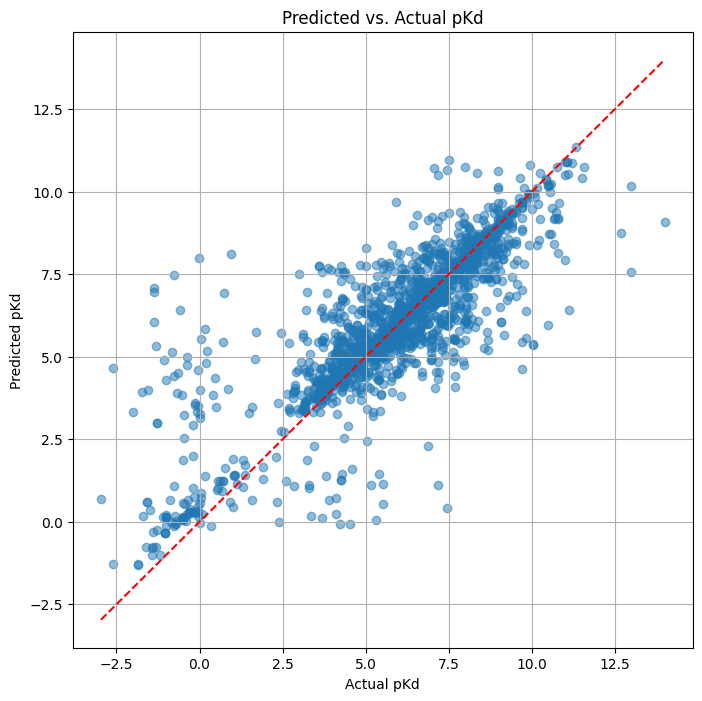

In [ ]:
def plot_predictions_vs_actual(model, loader, device):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            preds = model(batch).squeeze().cpu().numpy()
            targets = batch.y.squeeze().cpu().numpy()

            # Handle cases where preds or targets might be single values
            if preds.ndim == 0:
                preds = np.array([preds])
            if targets.ndim == 0:
                targets = np.array([targets])

            all_preds.extend(preds)
            all_targets.extend(targets)

    plt.figure(figsize=(8, 8))
    plt.scatter(all_targets, all_preds, alpha=0.5)
    plt.xlabel("Actual pKd")
    plt.ylabel("Predicted pKd")
    plt.title("Predicted vs. Actual pKd")
    plt.grid(True)

    # Add a diagonal line for perfect prediction
    min_val = min(min(all_targets), min(all_preds))
    max_val = max(max(all_targets), max(all_preds))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')

    plt.show()

# Use the trained model (debug_model) and the test_loader
plot_predictions_vs_actual(model, test_loader, device=device)

**BENCHMARKING**

In [ ]:
from google.colab import drive
import pickle
import os

# 1. Mount Google Drive (if not already mounted in the current session)
print("Mounting Google Drive...")
drive.mount('/content/drive', force_remount=True)


# 2. Define the exact path to your file
destination_folder = '/content/drive/MyDrive/graph_folders'
file_name = "processed_datasets.pkl" # Make sure this matches the saved file name
file_path = os.path.join(destination_folder, file_name)

# 3. Load the file
print(f"Attempting to load data from: {file_path}")

try:
    with open(file_path, "rb") as f:
        # Load the object back into a variable (e.g., loaded_data)
        loaded_data = pickle.load(f)

    # 4. Use the loaded data (which is the object previously named 'processed_data')
    print("Success! Data loaded. You can now use 'loaded_data' to train your model.")
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found. Please check the folder and file name.")
except Exception as e:
    print(f"An error occurred while loading the file: {e}")

core_test_graphs = loaded_data["test"]
core_test_loader = DataLoader(core_test_graphs, batch_size=32)

Mounting Google Drive...
Mounted at /content/drive
Attempting to load data from: /content/drive/MyDrive/graph_folders/processed_datasets.pkl
Success! Data loaded. You can now use 'loaded_data' to train your model.


In [ ]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 6.0 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=f17a64fb88525544ca91a3e3dac270cc24c748d94cbeb02decb25e80d8747c12
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


In [ ]:
import numpy as np
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
from lifelines.utils import concordance_index

def evaluate_model(model, loader, device):
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            preds = model(batch).squeeze().cpu().numpy()
            targets = batch.y.squeeze().cpu().numpy()

            # Ensure 1D arrays
            if preds.ndim == 0: preds = np.array([preds])
            if targets.ndim == 0: targets = np.array([targets])

            predictions.extend(preds)
            actuals.extend(targets)

    actuals = np.array(actuals)
    predictions = np.array(predictions)

    # --- CRITICAL FIX: Handle NaNs ---
    # Check if there are any NaNs in predictions or targets
    if np.isnan(predictions).any() or np.isnan(actuals).any():
        print(f"⚠️ WARNING: Found NaNs! (Preds: {np.isnan(predictions).sum()}, Targets: {np.isnan(actuals).sum()})")
        print("   -> Filtering out NaN values to allow metric calculation...")

        # Create a mask to keep only valid entries
        mask = ~np.isnan(actuals) & ~np.isnan(predictions)
        actuals = actuals[mask]
        predictions = predictions[mask]

        if len(actuals) == 0:
            print("❌ ERROR: All data points were NaN. Cannot calculate metrics.")
            return 0, 0, 0, 0, 0, 0, 0

    # --- Metrics Calculation ---

    # 1. MSE
    mse = mean_squared_error(actuals, predictions)

    # 2. RMSE
    rmse = np.sqrt(mse)

    # 3. MAE
    mae = mean_absolute_error(actuals, predictions)

    # 4. PCC / R
    if len(actuals) > 1:
        pcc, _ = pearsonr(actuals, predictions)
    else:
        pcc = 0.0
    r_val = pcc

    # 5. SD
    residuals = actuals - predictions
    sd = np.std(residuals)

    # 6. CI
    try:
        ci = concordance_index(actuals, predictions)
    except Exception:
        ci = 0.5

    # --- Reporting ---
    print(f"  R (Pearson) / PCC : {r_val:.4f}")
    print(f"  RMSE              : {rmse:.4f}")
    print(f"  MAE               : {mae:.4f}")
    print(f"  SD (Error)        : {sd:.4f}")
    print(f"  CI                : {ci:.4f}")
    print(f"  MSE               : {mse:.4f}")

    return r_val, rmse, mae, sd, ci, mse, pcc

# Usage
print("Evaluating on Test Set:")
r, rmse, mae, sd, ci, mse, pcc = evaluate_model(model, core_test_loader, device)

Evaluating on Test Set:
⚠️ WARNING: Found NaNs! (Preds: 3, Targets: 0)
   -> Filtering out NaN values to allow metric calculation...
  R (Pearson) / PCC : 0.3722
  RMSE              : 2.1938
  MAE               : 1.7568
  SD (Error)        : 2.1938
  CI                : 0.6329
  MSE               : 4.8130


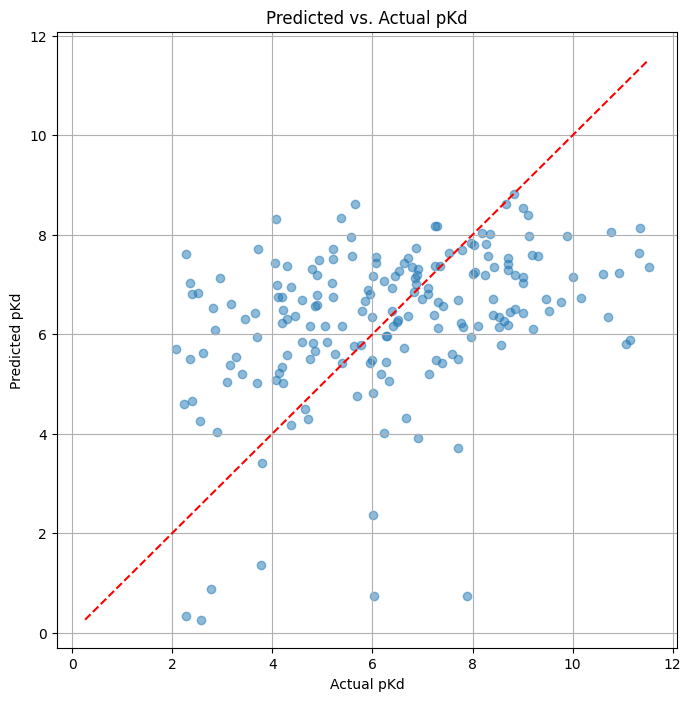

In [ ]:
def plot_predictions_vs_actual(model, loader, device):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            preds = model(batch).squeeze().cpu().numpy()
            targets = batch.y.squeeze().cpu().numpy()

            # Handle cases where preds or targets might be single values
            if preds.ndim == 0:
                preds = np.array([preds])
            if targets.ndim == 0:
                targets = np.array([targets])

            all_preds.extend(preds)
            all_targets.extend(targets)

    plt.figure(figsize=(8, 8))
    plt.scatter(all_targets, all_preds, alpha=0.5)
    plt.xlabel("Actual pKd")
    plt.ylabel("Predicted pKd")
    plt.title("Predicted vs. Actual pKd")
    plt.grid(True)

    # Add a diagonal line for perfect prediction
    min_val = min(min(all_targets), min(all_preds))
    max_val = max(max(all_targets), max(all_preds))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')

    plt.show()

# Use the trained model (debug_model) and the test_loader
plot_predictions_vs_actual(model, core_test_loader, device=device)

In [ ]:
import numpy as np
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
from lifelines.utils import concordance_index

def evaluate_model(model, loader, device):
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            preds = model(batch).squeeze().cpu().numpy()
            targets = batch.y.squeeze().cpu().numpy()

            # Ensure 1D arrays
            if preds.ndim == 0: preds = np.array([preds])
            if targets.ndim == 0: targets = np.array([targets])

            predictions.extend(preds)
            actuals.extend(targets)

    actuals = np.array(actuals)
    predictions = np.array(predictions)

    # --- CRITICAL FIX: Handle NaNs ---
    # Check if there are any NaNs in predictions or targets
    if np.isnan(predictions).any() or np.isnan(actuals).any():
        print(f"⚠️ WARNING: Found NaNs! (Preds: {np.isnan(predictions).sum()}, Targets: {np.isnan(actuals).sum()})")
        print("   -> Filtering out NaN values to allow metric calculation...")

        # Create a mask to keep only valid entries
        mask = ~np.isnan(actuals) & ~np.isnan(predictions)
        actuals = actuals[mask]
        predictions = predictions[mask]

        if len(actuals) == 0:
            print("❌ ERROR: All data points were NaN. Cannot calculate metrics.")
            return 0, 0, 0, 0, 0, 0, 0

    # --- Metrics Calculation ---

    # 1. MSE
    mse = mean_squared_error(actuals, predictions)

    # 2. RMSE
    rmse = np.sqrt(mse)

    # 3. MAE
    mae = mean_absolute_error(actuals, predictions)

    # 4. PCC / R
    if len(actuals) > 1:
        pcc, _ = pearsonr(actuals, predictions)
    else:
        pcc = 0.0
    r_val = pcc

    # 5. SD
    residuals = actuals - predictions
    sd = np.std(residuals)

    # 6. CI
    try:
        ci = concordance_index(actuals, predictions)
    except Exception:
        ci = 0.5

    # --- Reporting ---
    print(f"  R (Pearson) / PCC : {r_val:.4f}")
    print(f"  RMSE              : {rmse:.4f}")
    print(f"  MAE               : {mae:.4f}")
    print(f"  SD (Error)        : {sd:.4f}")
    print(f"  CI                : {ci:.4f}")
    print(f"  MSE               : {mse:.4f}")

    return r_val, rmse, mae, sd, ci, mse, pcc

# Usage
print("Evaluating on Test Set:")
r, rmse, mae, sd, ci, mse, pcc = evaluate_model(model, test_loader, device)

Evaluating on Test Set:
  R (Pearson) / PCC : 0.8263
  RMSE              : 1.4263
  MAE               : 0.8615
  SD (Error)        : 1.4207
  CI                : 0.8362
  MSE               : 2.0344


In [ ]:
!pip install seaborn matplotlib  # Install if missing

import seaborn as sns
import matplotlib.pyplot as plt

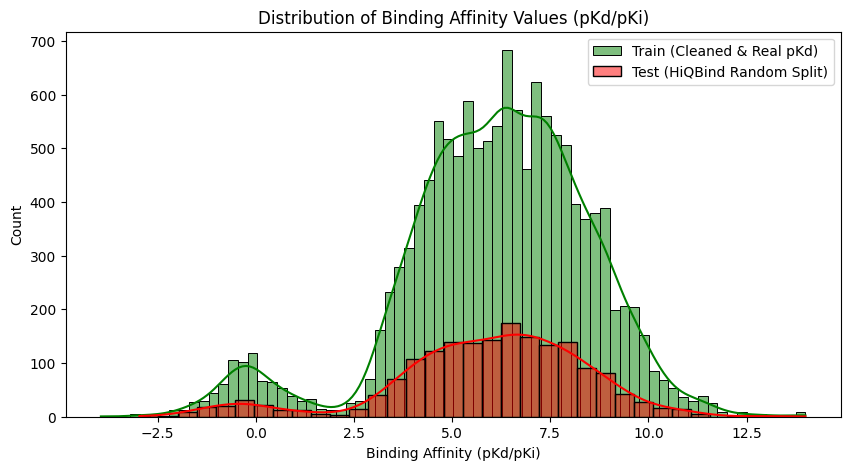

In [ ]:
# ==========================================
# 6. VISUALIZATION
# ==========================================
plt.figure(figsize=(10, 5))

if len(clean_train_dataset) > 0:
    # Extract 'y' from the dictionary entries
    train_y_values = [entry['y'] for entry in clean_train_dataset.values()]
    sns.histplot(train_y_values, kde=True, color='green', label='Train (Cleaned & Real pKd)')

if len(clean_test_dataset) > 0:
    # Extract 'y' from the dictionary entries
    test_y_values = [entry['y'] for entry in clean_test_dataset.values()]
    sns.histplot(test_y_values, kde=True, color='red', label='Test (HiQBind Random Split)')

plt.title(f"Distribution of Binding Affinity Values (pKd/pKi)")
plt.xlabel("Binding Affinity (pKd/pKi)")
plt.legend()
plt.show()